In [1]:
import jax
import jax.numpy as jnp
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

In [2]:
seed = 42
key = random.PRNGKey(seed)

2024-07-17 10:31:36.176953: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Prior models

In [26]:
# dims = (128, 128)
dims = (1000, 1000)

# correlated field zero mode GP offset and stddev
cf_zm = dict(offset_mean=0.0, offset_std=(1e-3, 1e-4))
# correlated field fluctuations (mostly don't need tuning)
cf_fl = dict(
    fluctuations=(1e0, 5e-2), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-3e0, 1e-2), # power-spectrum slope in log-log space in frequency domain (Fourier space)
    flexibility=(1e0, 5e-1), # deviation from simple power-law
    asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm = jft.CorrelatedFieldMaker("cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl, prefix="ax1", non_parametric_kind="power"
)
gp = cfm.finalize()

res type: <class 'jaxlib.xla_extension.ArrayImpl'>
res: [[-1.84890677 -1.89187346 -1.96111083 ... -1.81148811 -1.85985479
  -1.85520553]
 [-1.83869944 -1.91231317 -1.89172817 ... -1.91066604 -1.79522543
  -1.8449784 ]
 [-1.83976969 -1.8354586  -1.92012374 ... -1.98099978 -1.87418572
  -1.80396668]
 ...
 [-1.77034441 -1.8894334  -1.89445676 ... -1.69829007 -1.66070578
  -1.75175905]
 [-1.96862632 -2.01373624 -2.03808764 ... -1.717575   -1.74592473
  -1.84906263]
 [-1.93607621 -2.04497662 -2.0563983  ... -1.73260424 -1.88017374
  -1.89852551]]
res shape: (1000, 1000)


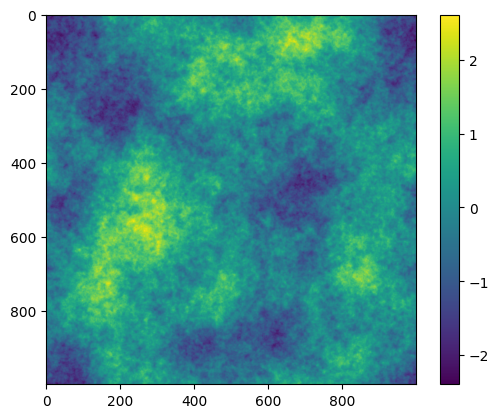

In [27]:
key, sub = random.split(key)
xi = jft.random_like(sub, gp.domain) # generate std normal parameters 
res = gp(xi) # draw sample from gp

print("res type:", type(res))
print("res:", res)
print("res shape:", res.shape)

plt.imshow(res)
plt.colorbar()
plt.show()

In [28]:
ps = jft.InvGammaPrior(
    a=5.0,
    scale=1.0,
    name="ps",
    shape=dims,
)

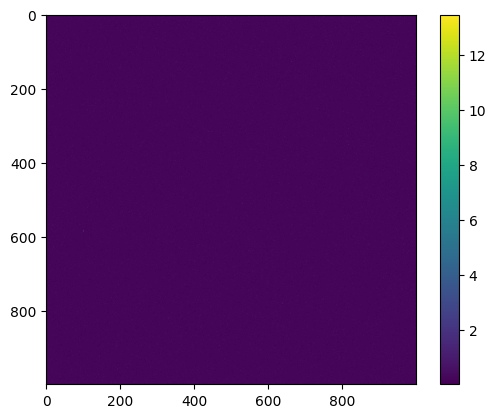

In [29]:
key, sub = random.split(key)
xi = jft.random_like(sub, ps.domain)
res = ps(xi)

plt.imshow(res)
plt.colorbar()
plt.show()

In [30]:
class Signal(jft.Model):
    def __init__(self, gp, ps):
        self.gp = gp
        self.ps = ps
        super().__init__(init=self.gp.init | self.ps.init)

    def __call__(self, x):
        return self.gp(x) + self.ps(x)


signal = Signal(gp, ps)

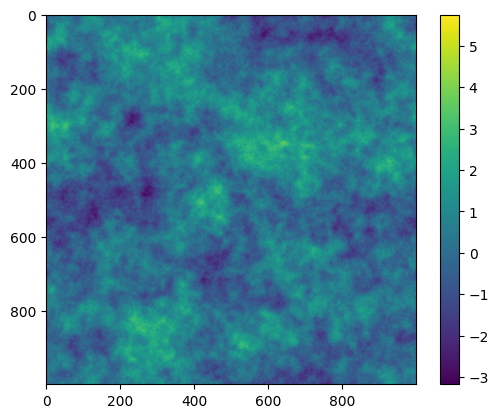

In [31]:
key, sub = random.split(key)
xi = jft.random_like(sub, signal.domain)
res = signal(xi)

plt.imshow(res)
plt.colorbar()
plt.show()

### Create mock data

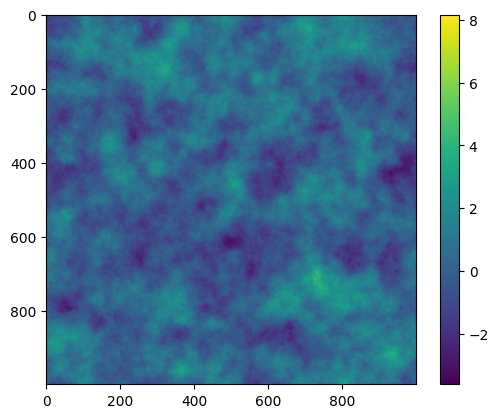

In [32]:
signal_response = signal

key, subkey = random.split(key)
pos_truth = jft.random_like(subkey, signal_response.domain)
signal_response_truth = signal_response(pos_truth)

noise_truth = 0.1 * jft.random_like(subkey, signal_response.target)

data = signal_response_truth + noise_truth

plt.imshow(data)
plt.colorbar()
plt.show()

### Likelihood

In [33]:
noise_cov_inv = lambda x: 0.1**-2 * x

lh = jft.Gaussian(data, noise_cov_inv).amend(signal_response)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


### Approximate posterior

Maximum A Posteriori (MAP) estimation

In [34]:
n_it = 1
delta = 1e-4
n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=35
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:4.550610e+02 ➽:2.158269e+02
M: Iteration 1 ⛰:+5.814376e+07 Δ⛰:3.161927e+07
M: →:0.5 ↺:False #∇²:12 |↘|:3.769422e+02 ➽:2.158269e+02
M: Iteration 2 ⛰:+3.034024e+07 Δ⛰:2.780352e+07
M: →:1.0 ↺:False #∇²:18 |↘|:1.913081e+02 ➽:2.158269e+02
M: Iteration 3 ⛰:+2.047235e+07 Δ⛰:9.867889e+06
OPTIMIZE_KL: Iteration 0001 ⛰:+2.0472e+07
OPTIMIZE_KL: #(KL minimization steps) 3
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 3.9e+01±     0.0, avg:  +0.0043±     0.0, #dof:1000000'

OPTIMIZE_KL: Prior residual(s):
cfax1asperity           :: 'reduced χ²:     4.2±     0.0, avg:     +2.1±     0.0, #dof:      1'
cfax1flexibility        :: 'reduced χ²:    0.43±     0.0, avg:    +0.65±     0.0, #dof:      1'
cfax1fluctuations       :: 'reduced χ²:     3.9±     0.0, avg:     -2.0±     0.0, #dof:      1'
cfax1loglogavgslope     :: 'reduced χ²:     1.8±     0.0, avg:     -1.3±     0.0, #dof:      1'
cfax1spectrum           :: 'reduced χ²:     1.0±     0.0, a

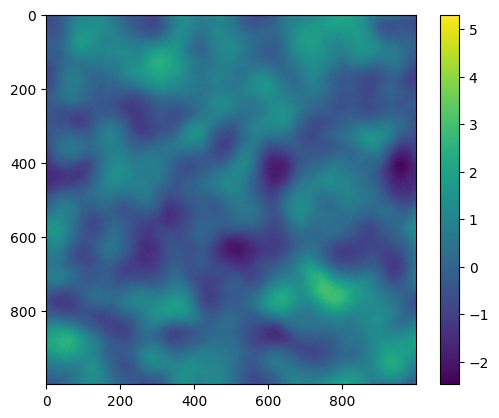

In [35]:
# plot maximum of posterior (mode)
sig_map = signal(samples.pos)

plt.imshow(sig_map)
plt.colorbar()
plt.show()

Geometric Variational Inference (GeoVI) -> Jakob's MGVI + nonlin updates

In [13]:
n_it = 5 # no of SL + SN + M
delta = 1e-4 # degree of tolerance
n_samples = 4 # *2 antithetic samples per n_it

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh,
    jft.Vector(lh.init(k_i)),
    n_total_iterations=n_it,
    n_samples=n_samples,
    key=k_o,
    draw_linear_kwargs=dict(
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict(
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict(
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=35
        )
    ),
    sample_mode="nonlinear_resample",
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+5.4879e+05 Δ⛰:inf ➽:3.6011e-01
SL: Iteration 1 ⛰:+3.0713e+05 Δ⛰:2.4167e+05 ➽:3.6011e-01
SL: Iteration 2 ⛰:+2.2058e+05 Δ⛰:8.6543e+04 ➽:3.6011e-01
SL: Iteration 3 ⛰:+1.7252e+05 Δ⛰:4.8068e+04 ➽:3.6011e-01
SL: Iteration 4 ⛰:+1.4373e+05 Δ⛰:2.8785e+04 ➽:3.6011e-01
SL: Iteration 5 ⛰:+1.1586e+05 Δ⛰:2.7871e+04 ➽:3.6011e-01
SL: Iteration 6 ⛰:+1.0179e+05 Δ⛰:1.4066e+04 ➽:3.6011e-01
SL: Iteration 7 ⛰:+8.7886e+04 Δ⛰:1.3909e+04 ➽:3.6011e-01
SL: Iteration 8 ⛰:+7.6388e+04 Δ⛰:1.1498e+04 ➽:3.6011e-01
SL: Iteration 9 ⛰:+7.5133e+04 Δ⛰:1.2546e+03 ➽:3.6011e-01
SL: Iteration 10 ⛰:+6.3565e+04 Δ⛰:1.1569e+04 ➽:3.6011e-01
SL: Iteration 11 ⛰:+5.5491e+04 Δ⛰:8.0737e+03 ➽:3.6011e-01
SL: Iteration 12 ⛰:+5.1089e+04 Δ⛰:4.4019e+03 ➽:3.6011e-01
SL: Iteration 13 ⛰:+4.9714e+04 Δ⛰:1.3752e+03 ➽:3.6011e-01
SL: Iteration 14 ⛰:+4.4455e+04 Δ⛰:5.2593e+03 ➽:3.6011e-01
SL: Iteration 15 ⛰:+4.3970e+04 Δ⛰:4.8436e+02 ➽:3.6011e-01
SL: Iteration 16 ⛰:+3.9710e+04 Δ⛰:4.2602e+03 ➽:3.6011e-01
SL: 

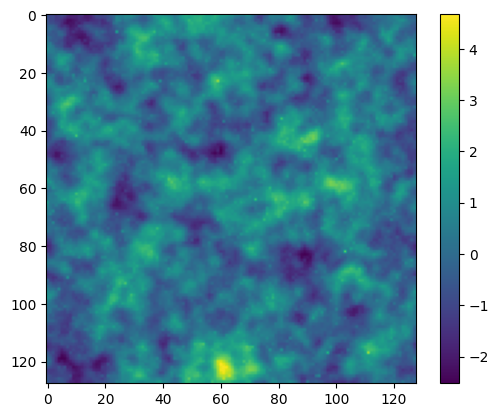

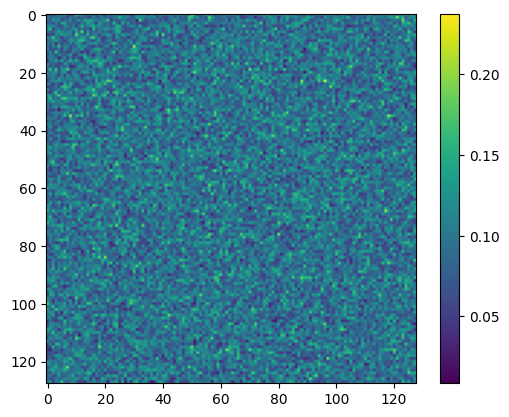

In [14]:
sig_mean, sig_std = jft.mean_and_std(tuple(signal(s) for s in samples))

plt.imshow(sig_mean)
plt.colorbar()
plt.show()

plt.imshow(sig_std)
plt.colorbar()
plt.show()

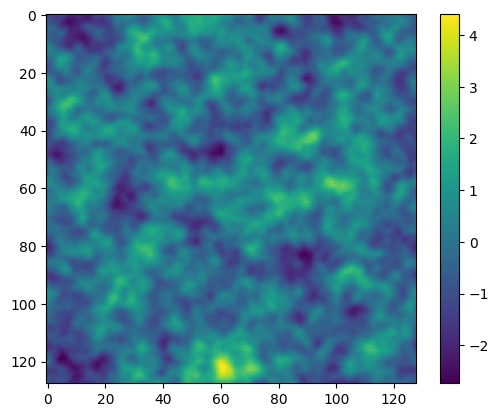

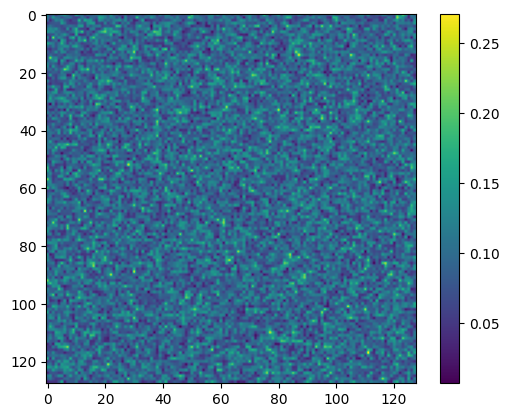

In [15]:
gp_mean, gp_std = jft.mean_and_std(tuple(gp(s) for s in samples))

plt.imshow(gp_mean)
plt.colorbar()
plt.show()

plt.imshow(gp_std)
plt.colorbar()
plt.show()

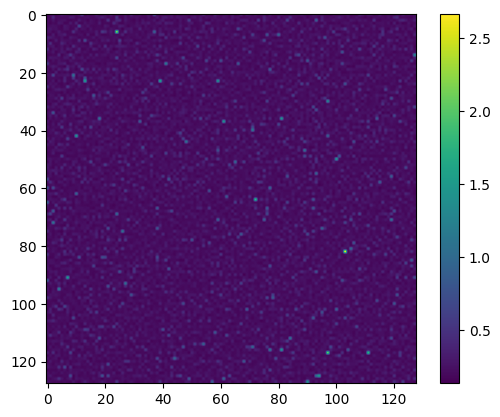

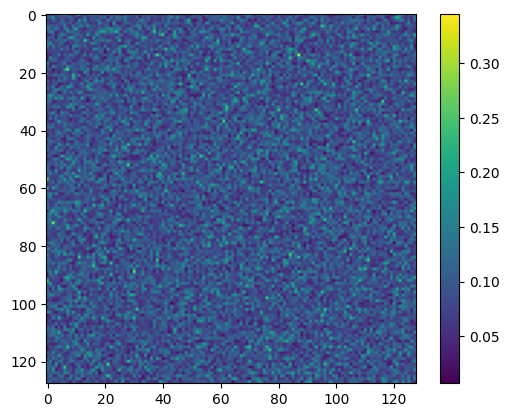

In [16]:
ps_mean, ps_std = jft.mean_and_std(tuple(ps(s) for s in samples))

plt.imshow(ps_mean)
plt.colorbar()
plt.show()

plt.imshow(ps_std)
plt.colorbar()
plt.show()

### Response function

In [17]:
class Response(jft.Model):
    def __init__(self, signal, mask):
        self.signal = signal
        self.mask = mask
        super().__init__(init=self.signal.init)

    def __call__(self, x):
        return self.mask * self.signal(x)


mask = jnp.ones(dims)
mask = mask.at[32:64, 32:64].set(0.0)

signal_response_masked = Response(signal, mask)

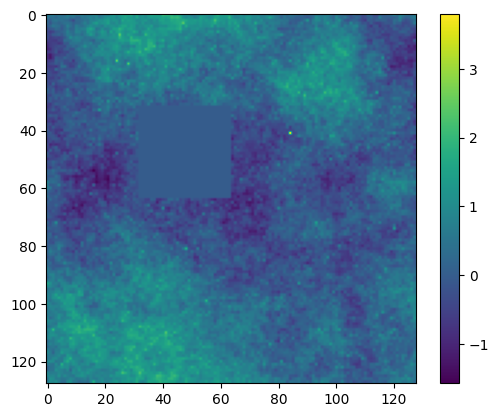

In [18]:
key, sub = random.split(key)
xi = jft.random_like(sub, signal_response_masked.domain)
res = signal_response_masked(xi)

plt.imshow(res)
plt.colorbar()
plt.show()

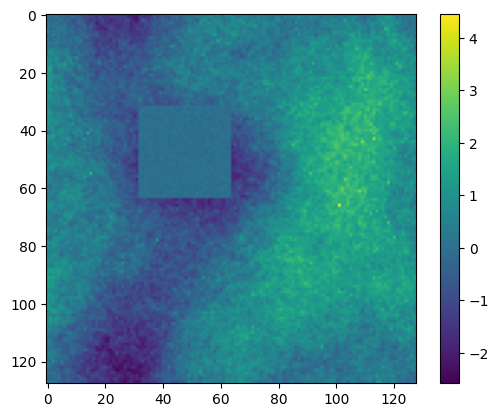

In [19]:
key, subkey = random.split(key)
pos_truth = jft.random_like(subkey, signal_response_masked.domain)
signal_response_masked_truth = signal_response_masked(pos_truth)

noise_truth = 0.1 * jft.random_like(subkey, signal_response_masked.target)

data_masked = signal_response_masked_truth + noise_truth

plt.imshow(data_masked)
plt.colorbar()
plt.show()

In [20]:
noise_cov_inv = lambda x: 0.1**-2 * x

lh_masked = jft.Gaussian(data_masked, noise_cov_inv).amend(signal_response_masked)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [21]:
n_it = 5
delta = 1e-4
n_samples = 4

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh_masked,
    jft.Vector(lh.init(k_i)),
    n_total_iterations=n_it,
    n_samples=n_samples,
    key=k_o,
    draw_linear_kwargs=dict(
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict(
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict(
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=35
        )
    ),
    sample_mode="nonlinear_resample",
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+9.0583e+05 Δ⛰:inf ➽:3.6011e-01
SL: Iteration 1 ⛰:+3.7666e+05 Δ⛰:5.2917e+05 ➽:3.6011e-01
SL: Iteration 2 ⛰:+1.6829e+05 Δ⛰:2.0837e+05 ➽:3.6011e-01
SL: Iteration 3 ⛰:+1.4098e+05 Δ⛰:2.7309e+04 ➽:3.6011e-01
SL: Iteration 4 ⛰:+1.0925e+05 Δ⛰:3.1735e+04 ➽:3.6011e-01
SL: Iteration 5 ⛰:+9.9696e+04 Δ⛰:9.5496e+03 ➽:3.6011e-01
SL: Iteration 6 ⛰:+8.8344e+04 Δ⛰:1.1352e+04 ➽:3.6011e-01
SL: Iteration 7 ⛰:+7.4098e+04 Δ⛰:1.4246e+04 ➽:3.6011e-01
SL: Iteration 8 ⛰:+7.0881e+04 Δ⛰:3.2173e+03 ➽:3.6011e-01
SL: Iteration 9 ⛰:+6.6969e+04 Δ⛰:3.9114e+03 ➽:3.6011e-01
SL: Iteration 10 ⛰:+5.9611e+04 Δ⛰:7.3583e+03 ➽:3.6011e-01
SL: Iteration 11 ⛰:+4.9127e+04 Δ⛰:1.0484e+04 ➽:3.6011e-01
SL: Iteration 12 ⛰:+4.5927e+04 Δ⛰:3.1999e+03 ➽:3.6011e-01
SL: Iteration 13 ⛰:+4.1795e+04 Δ⛰:4.1315e+03 ➽:3.6011e-01
SL: Iteration 14 ⛰:+3.5645e+04 Δ⛰:6.1505e+03 ➽:3.6011e-01
SL: Iteration 15 ⛰:+3.1734e+04 Δ⛰:3.9109e+03 ➽:3.6011e-01
SL: Iteration 16 ⛰:+2.7210e+04 Δ⛰:4.5240e+03 ➽:3.6011e-01
SL: 

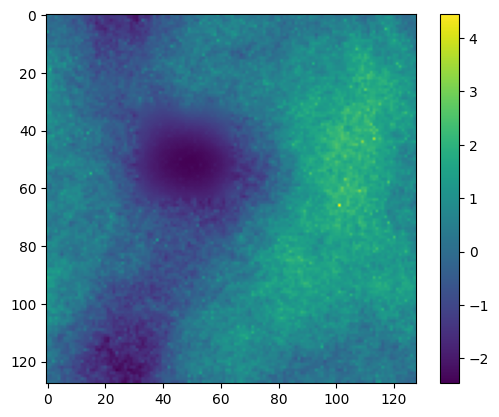

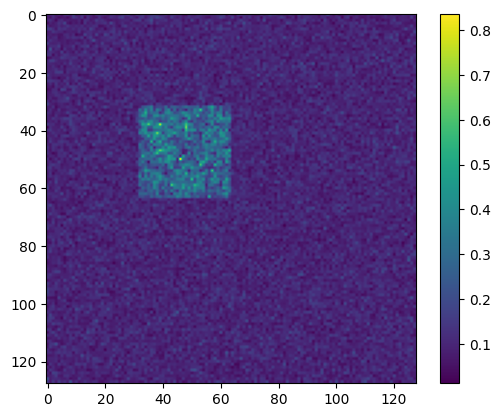

In [22]:
sig_mean, sig_std = jft.mean_and_std(tuple(signal(s) for s in samples))

plt.imshow(sig_mean)
plt.colorbar()
plt.show()

plt.imshow(sig_std)
plt.colorbar()
plt.show()